### Analisi nelle subreddit

Per valutare se la propensione la verbosità di un interazione utente post varia in funzione della size di un post, analizziamo:
- il numero di utenti univoci in un thread
- la distribuzione della lunghezza (in termini di numero di commenti) delle interazioni

Dividiamo quindi i thread in bins in base alla size, assicurandoci che per ogni bin ci siano almeno 1000 thread dentro, e su questi calcoliamo la distribuzione della lunghezza delle interazioni utente post facendo affidamento al parametro locator per vedere se la verbosità aumenta. (Tagliando le code, mettendo un upper clip per interazioni con più di 10 commenti).

Questo è stato fatto sia dividendo le conversazioni in base a gli anni in cui avvengono sia in base ai subreddit a cui appartengono.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from EXP_package.temporal_funcions import *
import os
from scipy.stats import entropy as calc_entropy


platform = 'reddit' # Chose 'reddit' , 'voat', 'facebook'
param = 'localizator'  # Choose 'localizator', 'alpha', or 'entropy'
upper_clip =10 # Maximum number of comments counted for an interaction len
bin_size= 5 # Steps of the categorization funcion
min_sample=100 # Minimum number of observations to plot a point
upper_xlim=300 # Maximum size taken under consideration

data = process_platform(platform, param)




## Aggregated

/tmp/ipykernel_625355/2820139122.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_params = data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))


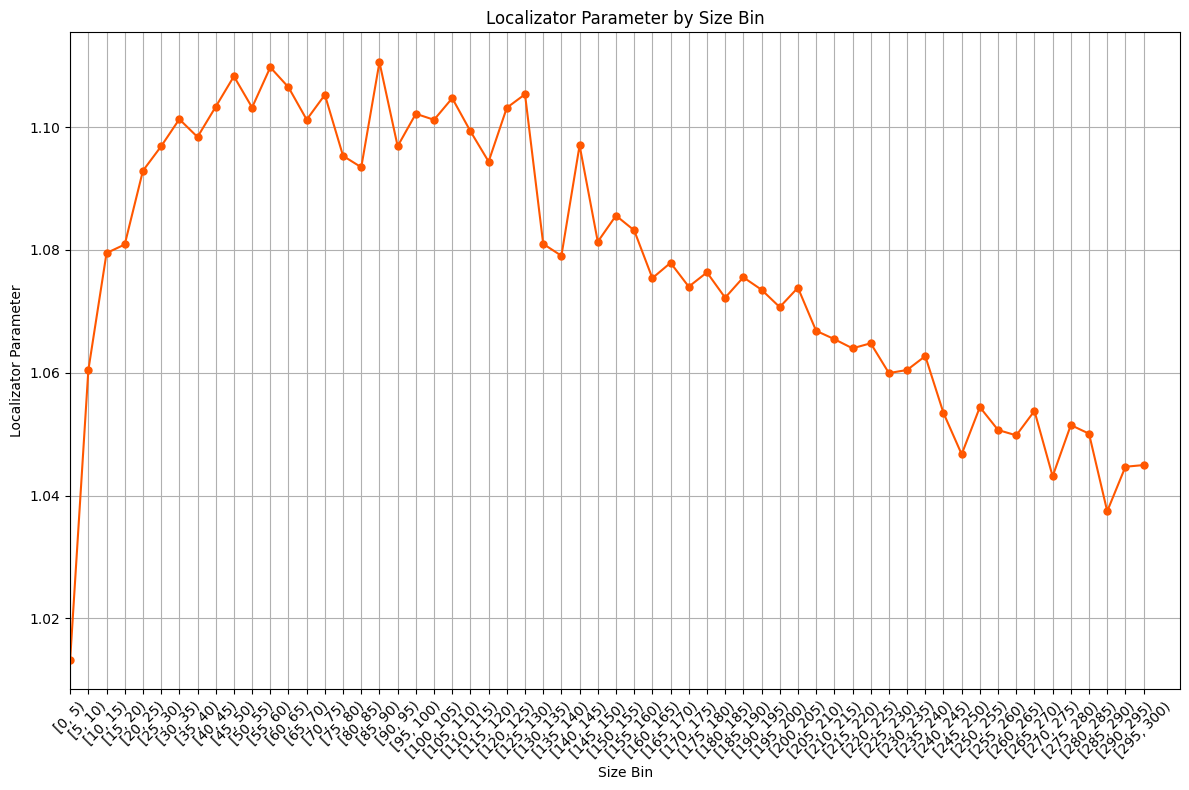

In [68]:
platform_colors = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'Gab': '#00c853',
    'Twitter': '#1DA1F2',
    'Usenet': '#7D7D7D'
}
color = platform_colors.get(platform, '#000000')



# Step 1: Calcola il numero di utenti unici per post
unique_user_counts = data.groupby('post_id')['user_id'].nunique().rename('size').reset_index()

# Step 2: Assicurati che le colonne 'post_id' siano dello stesso tipo per l'unione
data['post_id'] = data['post_id'].astype(str)
unique_user_counts['post_id'] = unique_user_counts['post_id'].astype(str)

# Step 3: Unisci i conteggi unici di utenti al dataset originale
data = data.merge(unique_user_counts, on='post_id', how='left')

# Step 4: Raggruppa per utente, post e dimensione, quindi calcola la lunghezza dell'interazione
data = data.groupby(['user_id', 'post_id', 'size']).agg(interaction_len=('user_id', 'count')).reset_index()

# Step 5: Limita la lunghezza delle interazioni a un massimo di 10
data['interaction_len'] = data['interaction_len'].clip(upper=upper_clip)

# Step 6: Definisci i range dei bin per la 'size' e raggruppa i dati in bin
max_size = int(data['size'].max())
if max_size>upper_xlim:
    data=data[data['size']<upper_xlim]
bins = range(0, upper_xlim + bin_size, bin_size)  # Assicurati che la dimensione massima sia inclusa
data['size_bin'] = pd.cut(data['size'], bins=bins, right=False)

# Step 7: Calcola il parametro di localizzazione per ogni bin di dimensioni
if param == 'localizator':
    location_params = data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))
elif param == 'alpha':
    location_params = data.groupby('size_bin')['interaction_len'].apply(calculate_alpha)
elif param == 'entropy':
    location_params = data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_entropy(x.value_counts(normalize=True)))

# Step 8: Filtra i bin con meno di 1000 voci valide
valid_bins = data['size_bin'].value_counts()
plot_data = location_params.copy()
plot_data[valid_bins < min_sample] = None

# Step 9: Plot dei risultati
plt.figure(figsize=(12, 8))
plt.plot(
    plot_data.index.astype(str),  
    plot_data,                  
    marker='o',                
    linestyle='-',  
    color=color,            
    markersize=5,               
    label=f'{param.capitalize()} Parameter'
)

plt.xlabel('Size Bin')              
plt.ylabel(f'{param.capitalize()} Parameter') 
plt.title(f'{param.capitalize()} Parameter by Size Bin')
plt.xticks(rotation=45)

# Imposta i limiti dell'asse x
plt.xlim(0, len(bins))  # Imposta il valore massimo dell'asse x

plt.tight_layout()
plt.grid(True)
output_file = os.path.join('/home/jacoponudo/Documents/Size_effects/PLT/7_temporal/', platform + f'_{param}_plot.png')
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()


## By Year

/tmp/ipykernel_625355/3082766121.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['post_id'] = year_data['post_id'].astype(str)
/tmp/ipykernel_625355/3082766121.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_params = year_data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))
/tmp/ipykernel_625355/3082766121.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

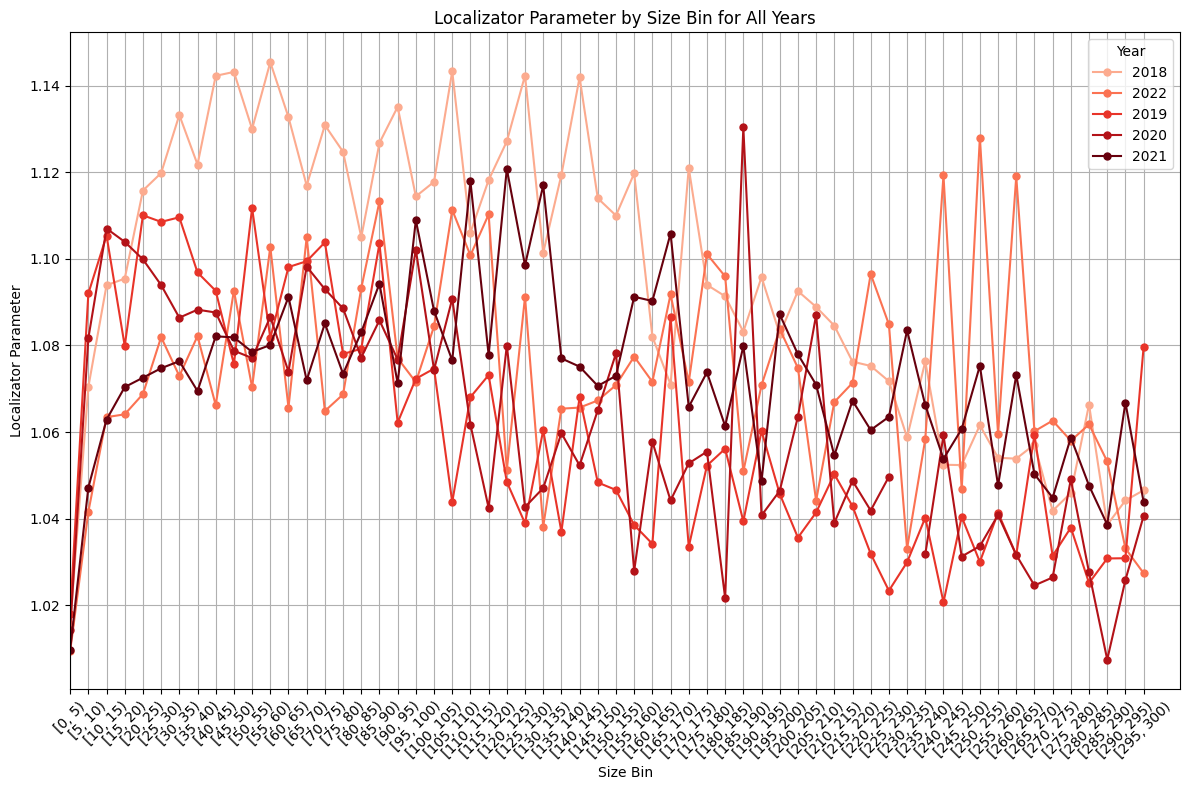

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Supponendo che 'data' abbia una colonna 'year' e 'date' in un formato datetime
data['year'] = data['date'].dt.year  # Assicurati che la colonna 'date' sia in formato datetime

# Definisci il colore base e genera sfumature
base_color = '#FF5700'  # Colore di base (es. rosso Reddit)
n_years = len(data['year'].unique())
colors = [plt.cm.Reds(i) for i in np.linspace(0.3, 1, n_years)]  # Crea sfumature di rosso

# Dizionario per memorizzare i parametri di localizzazione per ogni anno
all_years_data = {}

# Cicla attraverso gli anni unici nel dataset
for year in data['year'].unique():
    year_data = data[data['year'] == year]
    
    # Step 1: Calcola il numero di utenti unici per post
    unique_user_counts = year_data.groupby('post_id')['user_id'].nunique().rename('size').reset_index()

    # Step 2: Assicurati che le colonne 'post_id' siano dello stesso tipo per l'unione
    year_data['post_id'] = year_data['post_id'].astype(str)
    unique_user_counts['post_id'] = unique_user_counts['post_id'].astype(str)

    # Step 3: Unisci i conteggi unici di utenti al dataset originale
    year_data = year_data.merge(unique_user_counts, on='post_id', how='left')

    # Step 4: Raggruppa per utente, post e dimensione, quindi calcola la lunghezza dell'interazione
    year_data = year_data.groupby(['user_id', 'post_id', 'size']).agg(interaction_len=('user_id', 'count')).reset_index()

    # Step 5: Limita la lunghezza delle interazioni a un massimo di 10
    year_data['interaction_len'] = year_data['interaction_len'].clip(upper=upper_clip)

    # Step 6: Definisci i range dei bin per la 'size' e raggruppa i dati in bin
    max_size = int(year_data['size'].max())
    if max_size > upper_xlim:
        year_data = year_data[year_data['size'] < upper_xlim]
    bins = range(0, upper_xlim + bin_size, bin_size)  # Assicurati che la dimensione massima sia inclusa
    year_data['size_bin'] = pd.cut(year_data['size'], bins=bins, right=False)

    # Step 7: Calcola il parametro di localizzazione per ogni bin di dimensioni
    if param == 'localizator':
        location_params = year_data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_localization_parameter(x.value_counts(normalize=True)))
    elif param == 'alpha':
        location_params = year_data.groupby('size_bin')['interaction_len'].apply(calculate_alpha)
    elif param == 'entropy':
        location_params = year_data.groupby('size_bin')['interaction_len'].apply(lambda x: calculate_entropy(x.value_counts(normalize=True)))

    # Step 8: Filtra i bin con meno di 1000 voci valide
    valid_bins = year_data['size_bin'].value_counts()
    plot_data = location_params.copy()
    plot_data[valid_bins < min_sample] = None
    
    # Salva i dati di plot per l'anno corrente
    all_years_data[year] = plot_data

# Step 9: Plot dei risultati per tutti gli anni
plt.figure(figsize=(12, 8))

# Usa le sfumature per ogni anno
for i, (year, plot_data) in enumerate(all_years_data.items()):
    plt.plot(
        plot_data.index.astype(str),  
        plot_data,                  
        marker='o',                
        linestyle='-',  
        color=colors[i],            
        markersize=5,               
        label=f'{year}'
    )

plt.xlabel('Size Bin')              
plt.ylabel(f'{param.capitalize()} Parameter') 
plt.title(f'{param.capitalize()} Parameter by Size Bin for All Years')
plt.xticks(rotation=45)
plt.legend(title='Year')

# Imposta i limiti dell'asse x
plt.xlim(0, len(bins))  # Imposta il valore massimo dell'asse x

plt.tight_layout()
plt.grid(True)
output_file = os.path.join('/home/jacoponudo/Documents/Size_effects/PLT/7_temporal/', f'{platform}_{param}_all_years_plot.png')
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()
